In [1]:
import nltk
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from nltk.corpus import brown
from tqdm import tqdm

In [2]:
# datastructure for storing the id and val mapping
class unique_dict:
    def __init__(self):
        self.id = 0
        self.id2val = dict()
        self.val2id = dict()
        self.vals = set()
        
    def get_length(self):
        return self.id
    
    def store(self, val):
        self.id2val[self.id] = val
        self.val2id[val] = self.id
        self.vals.add(val)
        self.id += 1
    
    def fetch(self, key, by='id'):
        if by == 'id':
            return self.id2val[key]
        elif key in self.vals:
            return self.val2id[key]
        else:
            return None
        
unknown_prob =  0.000001

In [3]:
# splitting the corpus into two for now
train_corpus, test_corpus = train_test_split(brown.tagged_sents(tagset='universal'), test_size=0.2)

In [4]:
'''
    training functions
'''

def generate_unique_words(train_corpus):
    words = unique_dict()
    
    for tagged_sent in train_corpus:
        for (word, tag) in tagged_sent:
            if words.fetch(word.lower(), 'val') == None:
                words.store(word.lower())

    return words

def generate_unique_tags():
    tagset = set([tag for [word, tag] in brown.tagged_words(tagset='universal')])
    tags = unique_dict()
    
    for tag in tagset:
        if tags.fetch(tag, 'val') == None:
            tags.store(tag)
    
    return tags

'''
    Generates three useful matrices
    transition matrix for the tags
    emission matrix for the tag and word
    probability of occurence vector for tags
'''
def generate_useful_matrices(train_corpus, words, tags, unknown_prob= 0.0000001):
    cond_prob_tags = np.zeros([tags.id, tags.id])
    cond_prob_tag_word = np.zeros([tags.id, words.id])
    prob_tags = np.zeros([tags.id])
    
    tic = time.time()
    for tagged_sent in train_corpus:
        for index in range(len(tagged_sent)):
            word = tagged_sent[index][0]
            tag = tagged_sent[index][1]
            
            word_id = words.fetch(word.lower(), 'val')
            tag_id = tags.fetch(tag, 'val')
            
            prob_tags[tag_id] += 1
            cond_prob_tag_word[tag_id, word_id] += 1
            if index != len(tagged_sent) - 1:
                next_tag_id = tags.fetch(tagged_sent[index + 1][1], 'val')
                cond_prob_tags[tag_id, next_tag_id] += 1
    toc = time.time()
    print('Time elapsed for frequency computation:', toc - tic)
    
    tic = time.time()
    cond_prob_tags = np.divide(cond_prob_tags, np.reshape(prob_tags, [-1, 1]) + np.reshape(prob_tags == 0, [-1, 1]))
    cond_prob_tag_word = np.divide(cond_prob_tag_word, np.reshape(prob_tags, [-1, 1]) + np.reshape(prob_tags == 0, [-1, 1]))
    prob_tags = np.divide(prob_tags, np.sum(prob_tags))
    toc = time.time()
    print('Time elapsed for normalization:', toc - tic)
    
    # handling zero prob cases
    cond_prob_tags[cond_prob_tags == 0] = unknown_prob
    cond_prob_tag_word[cond_prob_tag_word == 0] = unknown_prob
    prob_tags[prob_tags == 0] = unknown_prob
    
    return cond_prob_tags, cond_prob_tag_word, prob_tags

In [5]:
# finding the words from the training corpus and obtaining overall tags
words = generate_unique_words(train_corpus)
tags = generate_unique_tags()

In [6]:
cond_prob_tags, cond_prob_tag_word, prob_tags = generate_useful_matrices(train_corpus, words, tags)

Time elapsed for frequency computation: 8.129273176193237
Time elapsed for normalization: 0.00598454475402832


In [7]:
'''
    Testing utils
'''

# vitterbi algorithm
def assign_pos(token_list, cond_prob_tags, cond_prob_tag_word, prob_tags, words, tags, unknown_prob=0.0000001):
    if len(token_list) == 0:
        return []
    
    score_matrix = np.zeros([tags.id, len(token_list)])
    back_pointer = np.zeros([tags.id, len(token_list)])
    
    # intialization
    word_id = words.fetch(token_list[0].lower(), 'val')
    for i in range(tags.id):
        if word_id == None:
            score_matrix[i, 0] = prob_tags[i] * unknown_prob
        else:
            score_matrix[i, 0] = prob_tags[i] * cond_prob_tag_word[i, word_id]
        back_pointer[i, 0] = -1;
            
    # Iteration Step
    for t in range(len(token_list)):
        if t != 0:
            for i in range(tags.id):
                word_id = words.fetch(token_list[t].lower(), 'val')
                total_transition_vector = np.multiply(score_matrix[:, t - 1], cond_prob_tags[:, i])
                arg_tag_max = np.argmax(total_transition_vector)
                back_pointer[i, t] = arg_tag_max
                if word_id == None:
                    score_matrix[i, t] = total_transition_vector[arg_tag_max] * unknown_prob
                else:
                    score_matrix[i, t] = total_transition_vector[arg_tag_max] * cond_prob_tag_word[i, word_id]
                    
    # sequence identification
    tag_index = np.zeros([len(token_list)])
    tag_index[-1] = np.argmax(score_matrix[:, len(token_list) - 1])
    for i in reversed(range(len(token_list) - 1)):
        tag_index[i] = back_pointer[int(tag_index[i + 1]), int(i + 1)]
    return [tags.fetch(index, 'id') for index in tag_index]

# function for analysing testing data
def analyze_test_data(test_corpus, cond_prob_tags, cond_prob_tag_word, prob_tags, words, tags, unknown_prob=0.000001):
    confusion_matrix = np.zeros([tags.id, tags.id], dtype=np.int32)
    
    for test_sent_tagged in tqdm(test_corpus):
        test_tag_list = [item[1] for item in test_sent_tagged]
        test_token_list = [item[0] for item in test_sent_tagged]
        
        predicted_tag_list = assign_pos(test_token_list, cond_prob_tags, cond_prob_tag_word, prob_tags, words, tags, unknown_prob)
        for (predicted_tag, test_tag) in zip(predicted_tag_list, test_tag_list):
            confusion_matrix[tags.fetch(predicted_tag, 'val'), tags.fetch(test_tag, 'val')] += 1
            
    return confusion_matrix

# function which does cross validation analysis by generating confusion matrix
def hmm_confusion(unknown_prob=0.0000001):
    tags = generate_unique_tags()
    confusion_matrix_train = np.zeros([tags.id, tags.id], dtype=np.int32)
    confusion_matrix_test = np.zeros([tags.id, tags.id], dtype=np.int32)
    tag_histogram = np.zeros([tags.id], dtype=np.float32)
    corpus = np.array(brown.tagged_sents(tagset='universal'))
    kf = KFold(n_splits=5, shuffle=True)
    kf.get_n_splits(corpus)
    
    for train_index, test_index in kf.split(corpus):
        train_corpus = corpus[train_index]
        test_corpus = corpus[test_index]
        print('training size:', len(train_index))
        print('testing size:', len(test_index))
        words = generate_unique_words(train_corpus)
        cond_prob_tags, cond_prob_tag_word, prob_tags = generate_useful_matrices(train_corpus, words, tags, unknown_prob)
        tag_histogram += prob_tags
        confusion_matrix_test += analyze_test_data(test_corpus, cond_prob_tags, cond_prob_tag_word, prob_tags, words, tags, unknown_prob)
        confusion_matrix_train += analyze_test_data(train_corpus, cond_prob_tags, cond_prob_tag_word, prob_tags, words, tags, unknown_prob)
        
    tag_histogram /= np.sum(tag_histogram)
    return confusion_matrix_train, confusion_matrix_test, tag_histogram

# to analyze the confusion matrix (to be tested)
def analyze_confusion(confusion_matrix, tag_histogram, tags, data='test'):
    
    # accuracy computation
    total_examples = np.sum(confusion_matrix)
    correct_predictions = np.trace(confusion_matrix)
    print('The overall accuracy of the hmm model is:', correct_predictions * 100 / total_examples)
    
    # storing the confusion matrix in the form of csv file
    tag_list = [tags.fetch(i, 'id') for i in range(tags.id)]
    confusion_df = pd.DataFrame(confusion_matrix, index=tag_list, columns=tag_list)
    confusion_df.to_csv('hmm_confusion_matrix_' + data + '.csv')
    
    # plotting the heat map
    plt.figure(figsize = (20, 20))
    confusion_figure = sns.heatmap(confusion_matrix, annot=True, xticklabels=tag_list, yticklabels=tag_list)
    plt.savefig('hmm_confusion_figure_' + data + '.png')
    
    # per POS tag statistics
    per_pos_dict = {'tag': [], 'precision': [], 'recall': [], 'f1-score': []}
    for tag_id in range(tags.id):
        per_pos_dict['precision'].append(confusion_matrix[tag_id, tag_id] / np.sum(confusion_matrix[tag_id, :]))
        per_pos_dict['recall'].append(confusion_matrix[tag_id, tag_id] / np.sum(confusion_matrix[:, tag_id]))
        per_pos_dict['tag'].append(tags.fetch(tag_id, 'id'))
        per_pos_dict['f1-score'].append(2 * per_pos_dict['precision'][tag_id] * per_pos_dict['recall'][tag_id] / (per_pos_dict['recall'][tag_id] + per_pos_dict['precision'][tag_id]))
    per_pos_df = pd.DataFrame(per_pos_dict)
    per_pos_df.to_csv('hmm_per_pos_accuracy_' + data + '.csv')
    
    # scatter plot for frequency vs f1-score for every tag
    tag_f1_score = np.nan_to_num(per_pos_dict['f1-score'])
    plt.figure()
    plt.scatter(tag_histogram, tag_f1_score)
    plt.title('Relative Frequency vs f1-score scatter plot')
    plt.xlabel('Relative Frequency of tag')
    plt.ylabel('F1 score')
    plt.savefig('hmm_scatter_plot_' + data + '.png')

In [8]:
test_sent = ['Some', 'newer', 'evidence', 'suggests', 'that', 'you', 'need', 'to', 'sleep', '.']
assign_pos(test_sent, cond_prob_tags, cond_prob_tag_word, prob_tags, words, tags)

['DET', 'ADJ', 'NOUN', 'VERB', 'ADP', 'PRON', 'VERB', 'PRT', 'VERB', '.']

In [9]:
confusion_matrix_train, confusion_matrix_test, tag_histogram = hmm_confusion()

training size: 45872
testing size: 11468


  0%|          | 23/11468 [00:00<00:52, 219.63it/s]

Time elapsed for frequency computation: 7.330806732177734
Time elapsed for normalization: 0.0049860477447509766


100%|██████████| 45872/45872 [02:34<00:00, 296.60it/s]


training size: 45872
testing size: 11468


  0%|          | 33/11468 [00:00<00:35, 324.40it/s]

Time elapsed for frequency computation: 6.959397077560425
Time elapsed for normalization: 0.003989458084106445


100%|██████████| 45872/45872 [02:37<00:00, 291.84it/s]


training size: 45872
testing size: 11468


  0%|          | 16/11468 [00:00<01:17, 148.60it/s]

Time elapsed for frequency computation: 7.21514892578125
Time elapsed for normalization: 0.003991127014160156


100%|██████████| 45872/45872 [02:34<00:00, 297.34it/s]


training size: 45872
testing size: 11468


  0%|          | 48/11468 [00:00<00:23, 476.53it/s]

Time elapsed for frequency computation: 7.213718414306641
Time elapsed for normalization: 0.003988981246948242


100%|██████████| 45872/45872 [02:35<00:00, 295.50it/s]


training size: 45872
testing size: 11468


  0%|          | 33/11468 [00:00<00:35, 321.24it/s]

Time elapsed for frequency computation: 6.946638822555542
Time elapsed for normalization: 0.003991603851318359


100%|██████████| 45872/45872 [02:37<00:00, 292.13it/s]


The overall accuracy of the hmm model is: 96.00350329661245


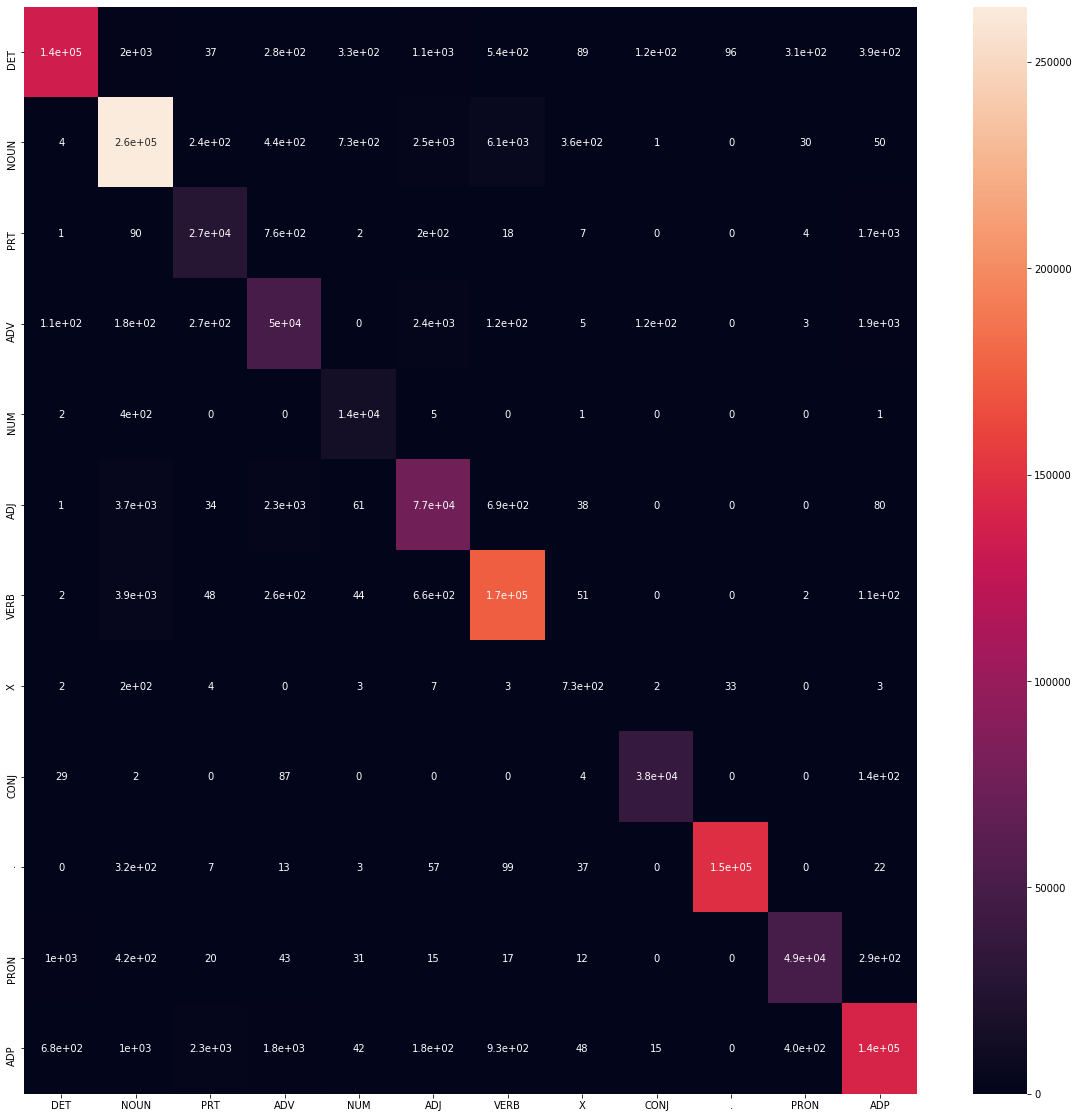

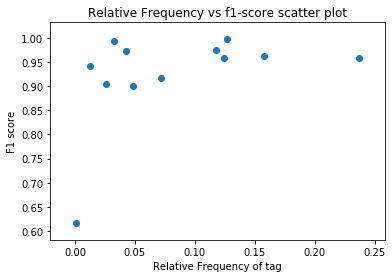

In [10]:
analyze_confusion(confusion_matrix_test, tag_histogram, tags, data='test')

The overall accuracy of the hmm model is: 97.35054581843485


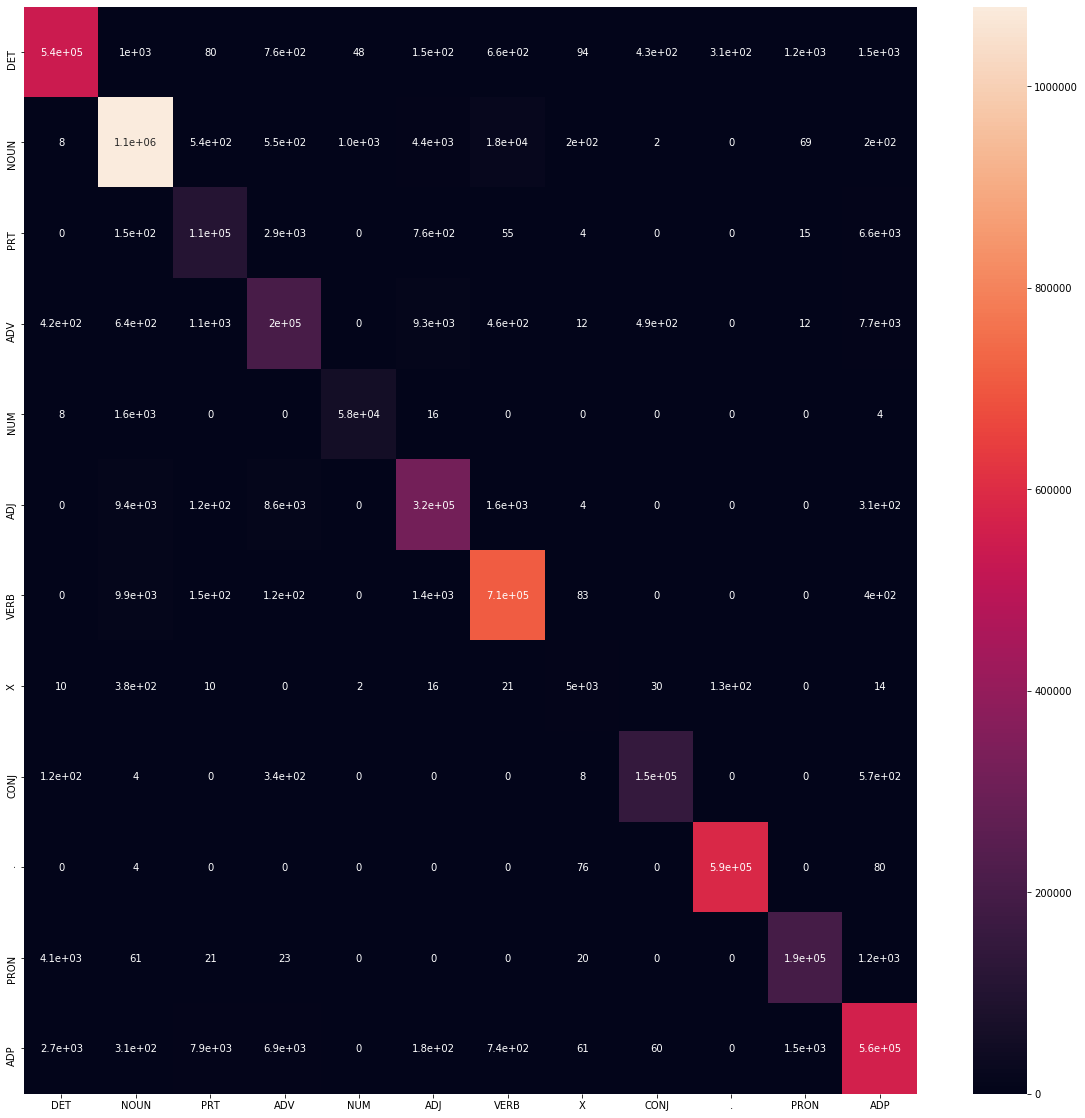

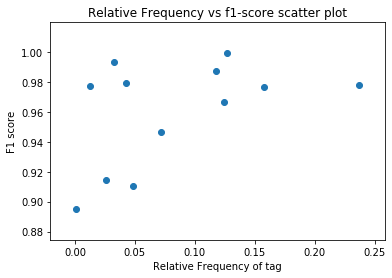

In [11]:
analyze_confusion(confusion_matrix_train, tag_histogram, tags, data='train')

training size: 45872
testing size: 11468


  0%|          | 17/11468 [00:00<01:07, 168.77it/s]

Time elapsed for frequency computation: 5.987990617752075
Time elapsed for normalization: 0.003991127014160156


100%|██████████| 45872/45872 [02:19<00:00, 328.50it/s]


training size: 45872
testing size: 11468


  0%|          | 31/11468 [00:00<00:38, 296.03it/s]

Time elapsed for frequency computation: 7.751271963119507
Time elapsed for normalization: 0.007979393005371094


100%|██████████| 45872/45872 [02:32<00:00, 300.61it/s]


training size: 45872
testing size: 11468


  0%|          | 40/11468 [00:00<00:29, 389.39it/s]

Time elapsed for frequency computation: 5.292847394943237
Time elapsed for normalization: 0.00399017333984375


100%|██████████| 45872/45872 [02:10<00:00, 350.66it/s]


training size: 45872
testing size: 11468


  0%|          | 26/11468 [00:00<00:44, 255.58it/s]

Time elapsed for frequency computation: 5.8683085441589355
Time elapsed for normalization: 0.004986286163330078


100%|██████████| 45872/45872 [02:16<00:00, 336.65it/s]


training size: 45872
testing size: 11468


  0%|          | 37/11468 [00:00<00:31, 367.32it/s]

Time elapsed for frequency computation: 5.802487134933472
Time elapsed for normalization: 0.004985332489013672


100%|██████████| 45872/45872 [02:37<00:00, 291.60it/s]


training size: 45872
testing size: 11468


  0%|          | 31/11468 [00:00<00:37, 307.75it/s]

Time elapsed for frequency computation: 5.6967692375183105
Time elapsed for normalization: 0.003988981246948242


100%|██████████| 45872/45872 [02:25<00:00, 315.38it/s]


training size: 45872
testing size: 11468


  0%|          | 27/11468 [00:00<00:42, 268.04it/s]

Time elapsed for frequency computation: 5.608999252319336
Time elapsed for normalization: 0.003994941711425781


100%|██████████| 45872/45872 [02:37<00:00, 291.90it/s]


training size: 45872
testing size: 11468


  0%|          | 29/11468 [00:00<00:40, 284.80it/s]

Time elapsed for frequency computation: 6.515130281448364
Time elapsed for normalization: 0.003988504409790039


100%|██████████| 45872/45872 [02:42<00:00, 282.58it/s]


training size: 45872
testing size: 11468


  0%|          | 24/11468 [00:00<00:48, 235.93it/s]

Time elapsed for frequency computation: 5.91019606590271
Time elapsed for normalization: 0.005984067916870117


100%|██████████| 45872/45872 [02:38<00:00, 289.36it/s]


training size: 45872
testing size: 11468


  0%|          | 32/11468 [00:00<00:35, 317.67it/s]

Time elapsed for frequency computation: 6.298160791397095
Time elapsed for normalization: 0.003988742828369141


100%|██████████| 45872/45872 [02:39<00:00, 287.04it/s]


training size: 45872
testing size: 11468


  0%|          | 25/11468 [00:00<00:46, 248.18it/s]

Time elapsed for frequency computation: 6.252982139587402
Time elapsed for normalization: 0.004987955093383789


100%|██████████| 45872/45872 [02:32<00:00, 300.71it/s]


training size: 45872
testing size: 11468


  0%|          | 40/11468 [00:00<00:28, 397.10it/s]

Time elapsed for frequency computation: 6.611320495605469
Time elapsed for normalization: 0.003989219665527344


100%|██████████| 45872/45872 [02:15<00:00, 339.76it/s]


training size: 45872
testing size: 11468


  0%|          | 30/11468 [00:00<00:39, 289.24it/s]

Time elapsed for frequency computation: 6.050821304321289
Time elapsed for normalization: 0.004985809326171875


100%|██████████| 45872/45872 [02:38<00:00, 288.69it/s]


training size: 45872
testing size: 11468


  0%|          | 25/11468 [00:00<00:47, 238.73it/s]

Time elapsed for frequency computation: 7.633589744567871
Time elapsed for normalization: 0.003991603851318359


100%|██████████| 45872/45872 [02:38<00:00, 288.86it/s]


training size: 45872
testing size: 11468


  0%|          | 41/11468 [00:00<00:28, 395.28it/s]

Time elapsed for frequency computation: 7.110521554946899
Time elapsed for normalization: 0.003988742828369141


100%|██████████| 45872/45872 [02:31<00:00, 303.24it/s]


training size: 45872
testing size: 11468


  0%|          | 26/11468 [00:00<00:45, 250.67it/s]

Time elapsed for frequency computation: 6.472693204879761
Time elapsed for normalization: 0.004985809326171875


100%|██████████| 45872/45872 [02:30<00:00, 305.23it/s]


training size: 45872
testing size: 11468


  0%|          | 32/11468 [00:00<00:36, 311.51it/s]

Time elapsed for frequency computation: 5.15621280670166
Time elapsed for normalization: 0.003987312316894531


100%|██████████| 45872/45872 [02:26<00:00, 313.58it/s]


training size: 45872
testing size: 11468


  0%|          | 39/11468 [00:00<00:30, 379.66it/s]

Time elapsed for frequency computation: 5.291851282119751
Time elapsed for normalization: 0.005984783172607422


100%|██████████| 45872/45872 [02:12<00:00, 346.52it/s]


training size: 45872
testing size: 11468


  0%|          | 29/11468 [00:00<00:39, 287.91it/s]

Time elapsed for frequency computation: 5.20707631111145
Time elapsed for normalization: 0.00399017333984375


100%|██████████| 45872/45872 [02:23<00:00, 319.71it/s]


training size: 45872
testing size: 11468


  0%|          | 38/11468 [00:00<00:30, 373.57it/s]

Time elapsed for frequency computation: 6.6302735805511475
Time elapsed for normalization: 0.004987239837646484


100%|██████████| 45872/45872 [02:27<00:00, 311.32it/s]


training size: 45872
testing size: 11468


  0%|          | 28/11468 [00:00<00:42, 269.94it/s]

Time elapsed for frequency computation: 7.577739715576172
Time elapsed for normalization: 0.0049860477447509766


100%|██████████| 45872/45872 [02:36<00:00, 293.31it/s]


training size: 45872
testing size: 11468


  0%|          | 29/11468 [00:00<00:40, 285.07it/s]

Time elapsed for frequency computation: 8.652858018875122
Time elapsed for normalization: 0.004984855651855469


100%|██████████| 45872/45872 [02:36<00:00, 293.77it/s]


training size: 45872
testing size: 11468


  0%|          | 31/11468 [00:00<00:37, 307.75it/s]

Time elapsed for frequency computation: 7.785184860229492
Time elapsed for normalization: 0.003989458084106445


100%|██████████| 45872/45872 [02:55<00:00, 260.95it/s]


training size: 45872
testing size: 11468


  0%|          | 17/11468 [00:00<01:07, 168.77it/s]

Time elapsed for frequency computation: 5.858337640762329
Time elapsed for normalization: 0.004987001419067383


100%|██████████| 45872/45872 [02:12<00:00, 345.99it/s]


training size: 45872
testing size: 11468


  0%|          | 30/11468 [00:00<00:38, 294.90it/s]

Time elapsed for frequency computation: 4.657549619674683
Time elapsed for normalization: 0.004987478256225586


100%|██████████| 45872/45872 [02:18<00:00, 330.36it/s]


training size: 45872
testing size: 11468


  0%|          | 28/11468 [00:00<00:42, 269.95it/s]

Time elapsed for frequency computation: 6.415850639343262
Time elapsed for normalization: 0.003993988037109375


100%|██████████| 45872/45872 [02:18<00:00, 331.66it/s]


training size: 45872
testing size: 11468


  0%|          | 33/11468 [00:00<00:35, 318.16it/s]

Time elapsed for frequency computation: 5.33174204826355
Time elapsed for normalization: 0.003988742828369141


100%|██████████| 45872/45872 [02:21<00:00, 323.64it/s]


training size: 45872
testing size: 11468


  0%|          | 33/11468 [00:00<00:36, 312.16it/s]

Time elapsed for frequency computation: 6.7738893032073975
Time elapsed for normalization: 0.003988981246948242


100%|██████████| 45872/45872 [02:26<00:00, 313.16it/s]


training size: 45872
testing size: 11468


  0%|          | 26/11468 [00:00<00:46, 248.28it/s]

Time elapsed for frequency computation: 6.833728075027466
Time elapsed for normalization: 0.0069811344146728516


100%|██████████| 45872/45872 [02:23<00:00, 318.83it/s]


training size: 45872
testing size: 11468


  0%|          | 32/11468 [00:00<00:35, 317.68it/s]

Time elapsed for frequency computation: 6.084731340408325
Time elapsed for normalization: 0.003986835479736328


100%|██████████| 45872/45872 [02:18<00:00, 332.14it/s]


training size: 45872
testing size: 11468


  0%|          | 20/11468 [00:00<01:02, 183.98it/s]

Time elapsed for frequency computation: 6.713052034378052
Time elapsed for normalization: 0.004986286163330078


100%|██████████| 45872/45872 [02:15<00:00, 338.47it/s]


training size: 45872
testing size: 11468


  0%|          | 27/11468 [00:00<00:42, 268.04it/s]

Time elapsed for frequency computation: 6.248292922973633
Time elapsed for normalization: 0.004986286163330078


100%|██████████| 45872/45872 [02:20<00:00, 327.04it/s]


training size: 45872
testing size: 11468


  0%|          | 31/11468 [00:00<00:37, 301.78it/s]

Time elapsed for frequency computation: 5.37164044380188
Time elapsed for normalization: 0.003987550735473633


100%|██████████| 45872/45872 [02:21<00:00, 324.16it/s]


training size: 45872
testing size: 11468


  0%|          | 28/11468 [00:00<00:41, 275.24it/s]

Time elapsed for frequency computation: 5.407540798187256
Time elapsed for normalization: 0.003988742828369141


100%|██████████| 45872/45872 [02:31<00:00, 302.56it/s]


training size: 45872
testing size: 11468


  0%|          | 34/11468 [00:00<00:34, 327.80it/s]

Time elapsed for frequency computation: 7.13292932510376
Time elapsed for normalization: 0.003987550735473633


100%|██████████| 45872/45872 [02:07<00:00, 360.60it/s]


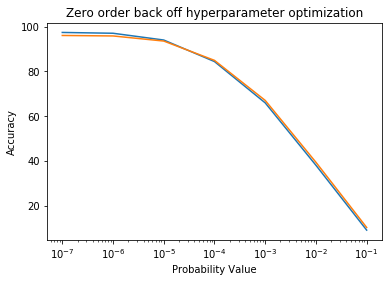

In [8]:
# unknown probability hyperparameter optimization
unknown_prob_list = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001]
test_accuracy = []
train_accuracy = []

# computation of confusion matrix for accuracy
for unknown_prob in unknown_prob_list:
    confusion_matrix_train, confusion_matrix_test, _ = hmm_confusion(unknown_prob)
    test_accuracy.append(100 * np.trace(confusion_matrix_test) / np.sum(confusion_matrix_test))
    train_accuracy.append(100 * np.trace(confusion_matrix_train) / np.sum(confusion_matrix_train))
    
# plotting the graph
plt.figure(1)
plt.title('Zero order back off hyperparameter optimization')
plt.xlabel('Probability Value')
plt.ylabel('Accuracy')
plt.xscale('log')
plt.plot(unknown_prob_list, train_accuracy, label='train_accuracy')
plt.plot(unknown_prob_list, test_accuracy, label='test_accuracy')
plt.show
plt.savefig('zero_order_back_off_optimization.png')

In [26]:
for index, relative_frequency in enumerate(tag_histogram):
    print(tags.fetch(index, 'id'), ':', relative_frequency)

NUM : 0.012809272
. : 0.12708071
VERB : 0.1573814
ADP : 0.124670185
ADV : 0.048431944
PRT : 0.02568824
DET : 0.11799852
X : 0.0011936161
PRON : 0.042485632
ADJ : 0.07209917
NOUN : 0.23730628
CONJ : 0.03285504


In [12]:
def compute_entropy_transitions(cond_prob_tags):
    log_cond_prob_tags = np.log(cond_prob_tags)
    return -np.sum(cond_prob_tags * log_cond_prob_tags, axis=1)

In [13]:
cond_entropy_vec = compute_entropy_transitions(cond_prob_tags)

In [14]:
for index, (entropy, tag_histogram) in enumerate(zip(cond_entropy_vec, tag_histogram)):
    print(tags.fetch(index, 'id'), ':', entropy, tag_histogram)

DET : 1.1325128960287243 0.11799832
NOUN : 1.8545714446697907 0.23730643
PRT : 1.4068052602500902 0.025688196
ADV : 2.1008441866047547 0.048432115
NUM : 1.7182536132735873 0.012809289
ADJ : 1.2893061132569743 0.072099194
VERB : 2.1800972045826827 0.15738137
X : 1.38595193131304 0.001193641
CONJ : 2.0423046923363963 0.03285494
. : 1.703649748647939 0.12708077
PRON : 1.1467809980323822 0.042485636
ADP : 1.602265317045005 0.12467013
